In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')


!pip install -U -q pyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/gdrive')


!pip install tensorflow

!pip install -q keras

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation,Input, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD, RMSprop
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
! pip install split-folders

In [ ]:
import splitfolders

In [ ]:
input_folder = "/content/gdrive/MyDrive/Colab Notebooks/data1"
output = "/content/gdrive/MyDrive/Colab Notebooks/data2"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.7,0.3))

Copying files: 5631 files [00:18, 308.35 files/s]


In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Colab Notebooks/data2/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

Found 3941 images belonging to 4 classes.


In [ ]:
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale = 1./255)
# test_set = test_datagen.flow_from_directory('/working/dataset/test',
#                                             target_size = (224, 224),
#                                             batch_size = 32,
#                                             class_mode = 'categorical')

In [ ]:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale = 1./255)

val_set = val_datagen.flow_from_directory('/content/gdrive/MyDrive/Colab Notebooks/data2/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 1690 images belonging to 4 classes.


In [ ]:
early = EarlyStopping(monitor='val_loss',patience=5)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

In [ ]:
output_classes = 4
batch_size = 32
epochs = 10
image_shape=(224,224,3)
nb_train_samples = 3941
nb_validation_samples = 1690
# nb_test_samples = 564

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=Input(shape=image_shape))

x = base_model.output
# x = GlobalAveragePooling2D()(x)
x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.6)(x)
x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.6)(x)
prediction = Dense(output_classes, activation=tf.nn.softmax)(x)

model = Model(inputs=base_model.input,outputs=prediction)
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
adam_opt=Adam(lr = 0.00001, beta_1=0.6, beta_2=0.9,amsgrad=True)

model.compile(optimizer= adam_opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import time
print("Training started it takes few minutes")
start_time = time.time()

history = model.fit(
  training_set,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = val_set,
  validation_steps = nb_validation_samples // batch_size,
  callbacks = [early, reduce])

print("successfully completed the traing session")
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Training started it takes few minutes
Epoch 1/10
123/123 [==============================] - 107s 456ms/step - loss: 0.4275 - accuracy: 0.9412 - val_loss: 10.6048 - val_accuracy: 0.2548 - lr: 0.0010
Epoch 2/10
123/123 [==============================] - 54s 442ms/step - loss: 0.3348 - accuracy: 0.9749 - val_loss: 25.7705 - val_accuracy: 0.2548 - lr: 0.0010
Epoch 3/10
123/123 [==============================] - 55s 450ms/step - loss: 0.2627 - accuracy: 0.9913 - val_loss: 18.6794 - val_accuracy: 0.2548 - lr: 0.0010
Epoch 4/10
123/123 [==============================] - 55s 448ms/step - loss: 0.2692 - accuracy: 0.9898 - val_loss: 9.5823 - val_accuracy: 0.2548 - lr: 0.0010
Epoch 5/10
123/123 [==============================] - 55s 446ms/step - loss: 0.2536 - accuracy: 0.9900 - val_loss: 17.9596 - val_accuracy: 0.2548 - lr: 0.0010
Epoch 6/10
123/123 [==============================] - 55s 444ms/step - loss: 0.2328 - accuracy: 0.9974 - val_loss: 20.9365 - val_accuracy: 0.2548 - lr: 0.0010
Epoch 7/

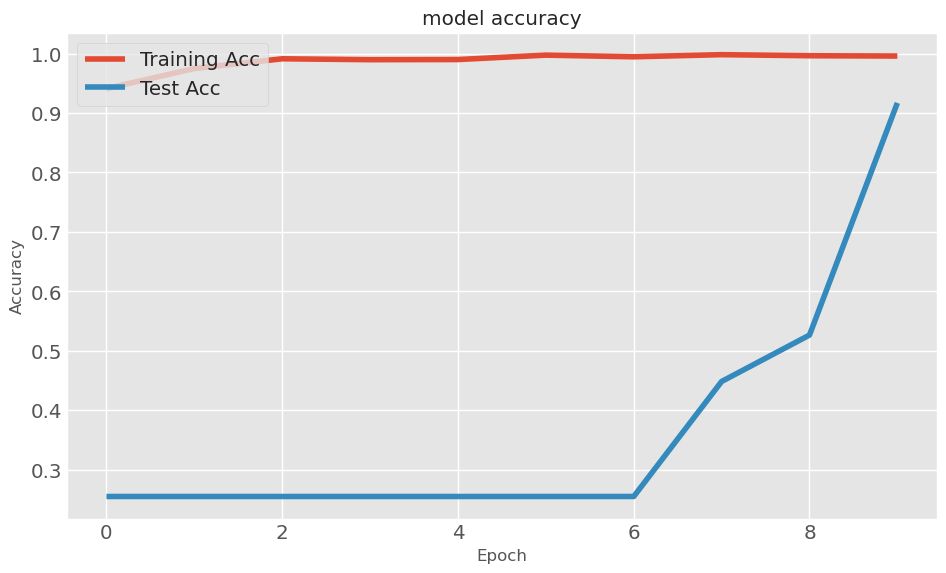

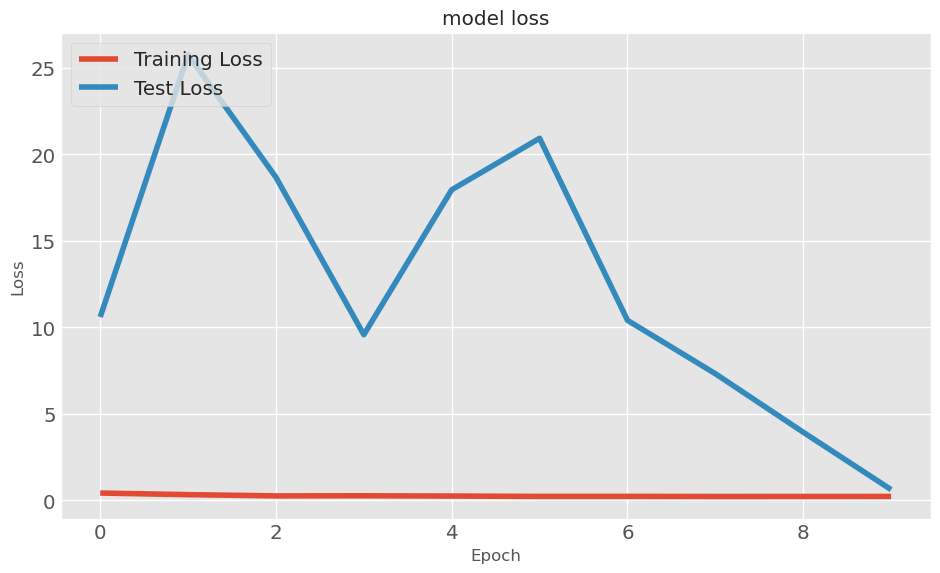

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate_generator(val_set, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.640999436378479
Validation Accuracy:  0.9137499928474426


In [ ]:
# accuracy_score = model.evaluate_generator(test_set, steps=50)
# print("Accuracy Score:", accuracy_score[0])
# print("Accuracy:",accuracy_score[1])

In [ ]:
_, acc = model.evaluate(val_set, verbose=1)
print('> %.3f' % (acc * 100.0))

53/53 [==============================] - 5s 87ms/step - loss: 0.6184 - accuracy: 0.9183
> 91.834


In [ ]:
model.save("Test" + '.h5')

### Model Evaluation

The evaluate_model function loads a trained model from a saved file and evaluates it using the validation generator. It calculates overall metrics (accuracy, precision, recall, F1-score) and class-specific metrics. These metrics provide a detailed view of model performance.

In [ ]:
def evaluate_model(saved_model_path, validation_generator):
    # Load the saved model
    loaded_model = tf.keras.models.load_model(saved_model_path)

    # Evaluate the model on the test set
    test_loss, test_accuracy = loaded_model.evaluate(validation_generator)
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)

    # Perform thorough evaluation
    y_true = validation_generator.classes
    y_pred = loaded_model.predict(validation_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate overall metrics
    accuracy = metrics.accuracy_score(y_true, y_pred_classes)
    precision = metrics.precision_score(y_true, y_pred_classes, average='weighted')
    recall = metrics.recall_score(y_true, y_pred_classes, average='weighted')
    f1_score = metrics.f1_score(y_true, y_pred_classes, average='weighted')

    print('Overall Metrics:')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-Score:', f1_score)

    # Calculate metrics per class
    class_metrics = metrics.classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
    print('\nMetrics per Class:')
    print(class_metrics)

In [ ]:
import sklearn.metrics as metrics
saved_model_path = '/content/gdrive/MyDrive/Colab Notebooks/Test.h5'

evaluate_model(saved_model_path, val_set)
# plot_training_history(history)

53/53 [==============================] - 5s 82ms/step - loss: 0.6184 - accuracy: 0.9183
Test Loss: 0.6184009909629822
Test Accuracy: 0.918343186378479
53/53 [==============================] - 5s 82ms/step
Overall Metrics:
Accuracy: 0.9183431952662722
Precision: 0.9375075473976572
Recall: 0.9183431952662722
F1-Score: 0.9179678866226003

Metrics per Class:
              precision    recall  f1-score   support

      cloudy       1.00      0.98      0.99       450
      desert       1.00      0.98      0.99       340
  green_area       1.00      0.73      0.84       450
       water       0.77      1.00      0.87       450

    accuracy                           0.92      1690
   macro avg       0.94      0.92      0.92      1690
weighted avg       0.94      0.92      0.92      1690

